# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
import nltk
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

import en_core_web_sm
nlp = en_core_web_sm.load

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [4]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [5]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot: xlabel='category'>

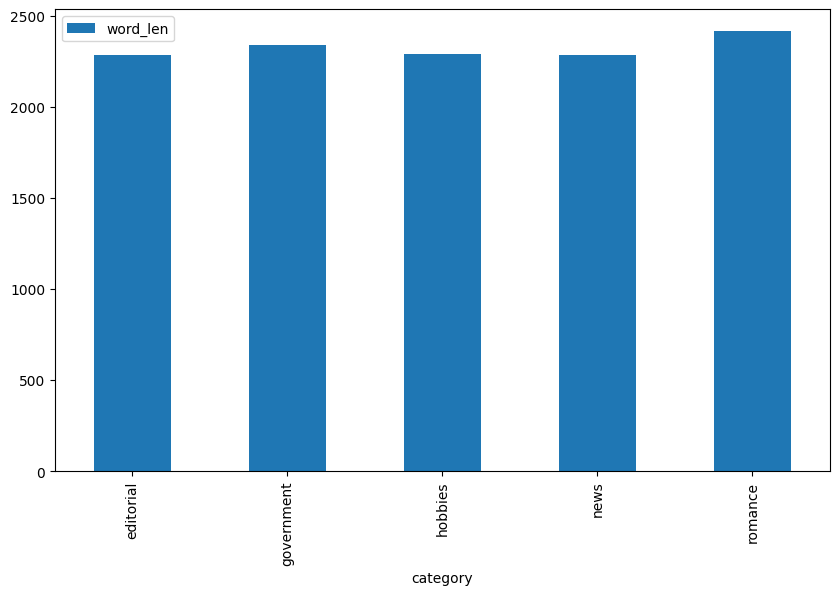

In [6]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [7]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [8]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The `count_text_vectors` data frame contains the frequency of occurrence of a word in the corpus. The columns represent words found in the corpus, while the rows represent documents within the corpus. The `tfidf_text_vectors` data frame holds both the frequency and the importance of the words in the corpus. The columns represent unique words in the corpus, while the rows represent the documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [9]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [10]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [11]:
# Store categories for each topic
nmf_topic_category = defaultdict(list)

for idx, row in enumerate(W_text_matrix):
    # Find the topic with the highest weight 
    nmf_topic = np.argmax(row)
    
    # Get the corresponding category
    nmf_category = df["category"].iloc[idx]

    # Append the category to the list of categories
    nmf_topic_category[nmf_topic].append(nmf_category)

In [12]:
# Sort the topics by topic number
sorted_topic_category = dict(sorted(nmf_topic_category.items()))

# Print topic category counts
for topic, categories in sorted_topic_category.items():
    print(f"Topic {topic} contains {len(categories)} documents")
    print("Category counts:")
    for category, count in Counter(categories).items():
        print(f"{category}: {count}")
    print()

Topic 0 contains 32 documents
Category counts:
editorial: 20
government: 4
news: 8

Topic 1 contains 41 documents
Category counts:
editorial: 4
romance: 29
hobbies: 8

Topic 2 contains 65 documents
Category counts:
editorial: 2
government: 26
news: 11
hobbies: 26

Topic 3 contains 18 documents
Category counts:
news: 17
hobbies: 1

Topic 4 contains 10 documents
Category counts:
editorial: 1
news: 8
hobbies: 1



Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model groups documents into broader themes that may not perfectly align with the original Brown corpus categories. The original Brown corpus has 15 distinct categories, each containing a different number of articles, whereas the NMF model has five topics. Topic 0 is predominantly captures editorial content, Topic 1 is primarily romance, Topic 2 consists of government and hobbies mainly, Topic 3 is predominantly composed of news topics with only one exception, and Topic 4 consists mainly of news topics with only two exceptions.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [13]:
# Create an instance of TruncatedSVD
svd_para_model = TruncatedSVD(n_components = 5, random_state = 42)

# Fit the model and transform the TF-IDF vectors
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)

# Get the components of the SVD model
H_svd_para_matrix = svd_para_model.components_

# Print topic category and their top terms
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


In [14]:
# Store categories for each topic
lsa_topic_category = defaultdict(list)

for idx, row in enumerate(W_svd_para_matrix):

    # Find the topic with the highest weight
    topic = np.where(row == np.amax(row))[0]

    # Get the corresponding category
    lsa_category = df["category"].iloc[idx]

    # Append the category to the list of categories
    lsa_topic_category[topic[0]].append(lsa_category)

In [15]:
# Sort the topics by topic number
sorted_lsa_topic_category = dict(sorted(lsa_topic_category.items()))

# Print topic category counts
for topic, categories in sorted_lsa_topic_category.items():
    print(f"Topic {topic} contains {len(categories)} documents")
    print("Category counts:")
    for category, count in Counter(categories).items():
        print(f"{category}: {count}")
    print()

Topic 0 contains 148 documents
Category counts:
editorial: 27
government: 30
news: 34
romance: 21
hobbies: 36

Topic 1 contains 8 documents
Category counts:
romance: 8

Topic 3 contains 3 documents
Category counts:
news: 3

Topic 4 contains 7 documents
Category counts:
news: 7



Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model does not align well with the original Brown categories. Topic 0 features a farily even distribution of topics, Topic 1 is entirely romance, and Topics 3 and 4 are entirely news.

In [16]:
# call display_topics on your model
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output? 

A: The display topics illustrate the underlying themes within the Brown corpus. Topic 0 appears to relate to political discussions as it includes terms such as `mr`, `said`, and `state`. Topic 1 is unclear as it includes general terms such as `said`, `thought`, and `got`. Topic 2 appears to be related to political discussions as it includes terms such as `said`, `kennedy`, and `president`. Topic 3 appears to center around activities in Texas as it includes terms such as `club`, `game`, and `dallas`. Topic 4 appears to cover sports as it includes terms such as `league`, `baseball`, and `ball`.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [17]:
# Fit your LDA model here
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

In [18]:
# Call `display_topics` on your fitted model here
display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model displays a wider range of categories for each topic, spanning editorial, government, news, hobbies, and romance. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The topics dervied from the LDA model are not completely representative of the original Brown categories. Topic 0 primarily consists of hobbies, topic 1 is government and hobbies, topic 2 is primarily news, topic 3 is primarily government, topic 4 is primarily romance with the exception of 3 documents.

In [19]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics = False)

In [20]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The principal component scatterplot provides a visual representation of each topic's distribution. From this, there is overlap between topics 2 and topic 3, as well as topic 2 and topic 4. The salient terms graph displays the frequency and terms for each of the topics. From this, the top five terms are `said`, `government`, `general`, `feed`, and `business`, which appear to relate to government or political-related corpus.